# Proyecto individual, notebook

El estudio buscarar establecer si hay una relacion entre el movimiento de mercancias en la ue y si este se ha podido ver afectado por la importacion de bienes de terceros paises. 
Por tanto,la pregunta principal a responder seria: ¿ el comercio intra europeo se ha visto afectado/ reducido por el comercio exterior?

Para ello se elaborara alguna gráfica del comercio intra y extra ue y se buscara elaborar una matriz de correlacion. 
origen de los datos url=https://ec.europa.eu/eurostat/web/main/data/database#Data%20navigation%20tree



In [159]:
# primero importamos las librerias que podrian sernos de utilidad 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [160]:
# importamos los datos dados desde el archivo. este archivo nos devuelve un conjunto de datos 
# ordenador por exp/imp, por pais y en frecuencia relativa y absoluta. 
# problema ->  que la primera columna esta toda unida y no lo distigue. tendremos que ordenar la tabla y separar esa columna.

datos_originales_1=pd.read_csv("estat_tet00011.tsv",sep="\t")
pd.set_option("display.max_rows", 200) # forzamos a que nos represente todas las columnas y filas.
cuadro_nombre=pd.read_csv("codigo_nombre.csv",)



In [ ]:
# antes de iniciar ninguna otra actividad vamos a desenrrollar la primera columna con el fin de que 
# podamos trabajar mejor con ella y podernos valer de ella para los indices o otras cosas
# lo encapsulamos en una funcion ya que la utilizaremos mas de 1 vez

def arreglo_primera_columna(arg:pd.DataFrame):
    '''permite que, en caso de que la primera columna 
    tenga varios objetos separados por comas esta se desenvuelva 
    y nos de un dataframe
    devuelve un pd.DataFrame'''
    cuadrotemp=arg[arg.columns[0]] # filtramos el cuadro y nos quedamos con la primera columna
    primera=arg.columns[0].split(",") # creamos la lista de columnas con la primera linea
    valores_lista_temp=dict(cuadrotemp).values() #lo convertimos en un dict. perdemos la primera linea pero lo que buscamos son los valores. 
    lista_nueva_temp=[] # aqui metemos una nueva lista 
    [lista_nueva_temp.append(list(x.split(","))) for x in valores_lista_temp] # creamos una nueva lista con todos los datos, fila por fila.
    return pd.DataFrame(lista_nueva_temp,columns=primera)# creamos un nuevo DataFrame con los datos relacionados y desplegados.

Data1=arreglo_primera_columna(datos_originales_1)

In [162]:
# posteriormente vamos a unir los dos dataframe. dejando en el lado izquierdo lo que acabamos de calcular 
# y en el derecho el resto del dataFrame.
dfd=datos_originales_1[datos_originales_1.columns[1:]]# con esto conseguimos el DF para unirlo al otro.
cuadrofef=Data1.join(dfd)



In [ ]:
# ahora que ya tenemos juntado los datos es hora de borrar las columnas que no necesitamos y de quedarnos con los datos que realmente usaremos.
def limpieza_datos(arg:pd.DataFrame) -> dict:
    '''Esta función requiere que le pasemos un dataframe,
    nos devolverá un diccionario con varios dataframes según la columna indic_et'''
    arg1=arg.copy() # utilizamos el copy para evitar hacer cambios en la tabla original.
    
    
    # borramos las lineas de totales que tenemos, ponemos delante el nombre del pais y borramos las lineas que corespondan a los totales.
    
    # ponemos esta columna como indice
    arg1.set_index(arg1["geo\\TIME_PERIOD"],inplace=True,drop=True)
    # borramos las lineas molestas.
    arg1.drop("EU27_2020",inplace=True)
    # volvemos a crear un indice numerico.
    arg1.reset_index(inplace=True,drop=True)
    # quitamos algunas de las columnas que no nos aportan informacion.
    arg1.drop(axis='columns',labels=["freq","sitc06"],inplace=True)

    # una vez hecho esto dividimos los datos para quedarnos con los que queremos. 
    #print(cuadrofef["indic_et"].unique())
    # aqui abrimos un dicionario. y dentro del diccionario vamos a meter una parte de la lista conforme su tipo. 
    dicionario_temp={}
    for x in arg1["indic_et"].unique():
        # filtramos por la lista. 
        inter=arg1[arg1["indic_et"]==x]
        # reseteamos indice por dos motivos: uno que no nos guarde el anterior indice y 2 que nos permite hacer la concatenacion.
        inter.reset_index(inplace=True,drop=True)
        # concatenamos la tabla de nombre.
        inter=pd.concat([inter,cuadro_nombre],axis=1)
        # añadimos al dicionario que habiamos creado con el nombre.
        dicionario_temp[f"cuadro{x}"]=inter
    # el resultado de esto es que tenemos un dicionario llamado como le llamemos en donde tenemos varios dataframes 
    # uno por cada filtro. los usaremos posteriormente.
    return dicionario_temp


cuadrosintra=limpieza_datos(cuadrofef)






In [164]:
# vamos ahora a filtrar el cuadro para obtener los totales con el que haremos la comparacion posterior
def totales(arg:pd.DataFrame):
    '''devuelve los totales del DF cuadrofef y fef2'''
    arg1=arg.copy()
    arg1.set_index(arg1["geo\\TIME_PERIOD"],inplace=True,drop=True)
    return arg1[arg1["geo\\TIME_PERIOD"]=="EU27_2020"]




Una vez realizadas la limpieza de las tablas y su separación vamos a proceder a aplicar la misma lógica a las siguientes tablas. iniciamos asi el tratamiento de la segunda tabla, las importaciones y exportaciones fuera de la UE


In [165]:
datos_originales_2=pd.read_csv("estat_tet00012.tsv",sep="\t")

Como se ve tenemos el mismo problema en cuanto a la primera columna, con los mismos nombres de columna, todo igual. 

In [166]:
Data2=arreglo_primera_columna(datos_originales_2)
dfd2=datos_originales_2[datos_originales_2.columns[1:]]# con esto conseguimos el DF para unirlo al otro
cuadrofef2=Data2.join(dfd2)


In [167]:
cuadrosextra=limpieza_datos(cuadrofef2)




Una vez realizado todo esto disponemos de dos conjuntos de dicionarios con Dataframes. Uno de ello con el comercio dentro de la UE y otro de ellos con el comercio fuera de la UE.
La siguiente fase es juntarlos y y manipularlos para elaborar estadisticas.

In [ ]:

def ldbl(df):
    '''retorna el cuadro sin los espacios en blanco y traspuesto'''
    evolucion=df.copy() # este cuadro expresa la cantidad de exportaciones a otros paises de la UE.

   # en el encabezado existen espacios en blanco lo que nos dificulta. 
   # por tanto los quitamos.

    x=evolucion.iloc[:,3:-1].copy()
    x.columns = x.columns.str.replace(' ', '')
    x.replace(" ","",inplace=True)
    x.set_index("id",inplace=True)
    
    return x.T



def grafico_lineas(x,pais=False,total=False, escala:int=100000,tamaño:tuple=(12,8)):
    '''dibuja un grafico con la evolucion de la variable por años
    en caso de especificar pais devolvera el pais'''

    if pais==False:
        # creamos el grafico. que nos dara un grafico en el eje x el año, y en el y las contidades. la leyenda y las lineas las ponemos en esos colores.
        sns.lineplot(x,palette=sns.color_palette("husl", 28))
        # modificamos el tamaño del grafico para dar cabida a todo. 
        plt.gcf().set_size_inches(tamaño)
        # con esto colocamos la leyenda en el lado derecho de la imagen.usamos plt ya que seaborn se basa en ello. con loc escogemos la localizacion y el segundo que
        # funciona en conjuncion nos crea una caja en el sitio.
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        # nuevamente acudimos a matplotlib para ajustar el eje y para que nos muestre una escala mas aceptable.
        plt.gca().yaxis.set_major_locator(plt.MultipleLocator(escala))
        # hacemos aparecer la cuadricula
        plt.grid()
        # hacemos que el grafico empiece en 0
        plt.xlim(0)
        plt.ylim(0)
        

    else:
        datos=x[pais]
        escala=20000
        sns.lineplot(datos,palette=sns.color_palette("husl", 28))
        # modificamos el tamaño del grafico para dar cabida a todo. 
        plt.gcf().set_size_inches(tamaño)
        # con esto colocamos la leyenda en el lado derecho de la imagen.usamos plt ya que seaborn se basa en ello. con loc escogemos la localizacion y el segundo que
        # funciona en conjuncion nos crea una caja en el sitio.
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        # nuevamente acudimos a matplotlib para ajustar el eje y para que nos muestre una escala mas aceptable.
        plt.gca().yaxis.set_major_locator(plt.MultipleLocator(escala))
        plt.grid()
        plt.axhline(datos.mean())
        plt.xlim(0)
        plt.ylim(0)
    
    
#grafico_lineas(ldbl(cuadrosintra["cuadroMIO_EXP_VAL"]),mayores=("2013",90000))
def paises_mayores_grafico(x,año:int,cantidad:int):
    '''nos devuelve el grafico con los paises mas grandes que en el año seleccionado esten por encima de 
    cierta cantidad'''
    #limpiamos los datos para dejarlos accesibles
    op=ldbl(x)
    # trasponemos para operar con ello
    opt=op.T
    # filtramos segun el año y la cantidad. se formatea porque le pasamos un int
    normalm=opt[opt[f"{año}"]>cantidad]
    # retornamos un grafico con los paises que cumplan esa condicion
    return grafico_lineas(normalm.T)



In [169]:
# una vez llegados aqui vamos a coger los totales de cada cuadro tanto en el comercio intra ue como extra ue y vamos a ver si existe alguna correlacion entre ellos
# cuadros de trabajo y el comercio con el exterior.
comercio_intra=totales(cuadrofef).reset_index(drop=True)
comercio_exte=totales(cuadrofef2).reset_index(drop=True)
cuadro1=comercio_exte.iloc[3:].reset_index()
cuadro1_1=cuadro1.set_index("indic_et").iloc[:,5:]
cuadro1_2=cuadro1_1.T
cuadro1_3=cuadro1_2.corr()
cuadro1_2.columns=["MIO_EXP_VALExt","MIO_IMP_VALExt"]




In [170]:
# cuadro del comercio intra europa
cuadro2=comercio_intra.iloc[3:].reset_index()
cuadro2_1=cuadro2.set_index("indic_et").iloc[:,5:]
cuadro2_2=cuadro2_1.T
cuadro2_3=cuadro2_2.corr()

cuadro2_2.columns=["MIO_EXP_VALIntra","MIO_IMP_VALIntra"]



In [171]:
cuadro_final=pd.concat([cuadro1_2.T,cuadro2_2.T])
cuadro_final1=cuadro_final.T.copy()
cuadro_final.T.corr()


,MIO_EXP_VALExt,MIO_IMP_VALExt,MIO_EXP_VALIntra,MIO_IMP_VALIntra
MIO_EXP_VALExt,1.000000,0.947654,0.991288,0.990879
MIO_IMP_VALExt,0.947654,1.000000,0.964333,0.961343
MIO_EXP_VALIntra,0.991288,0.964333,1.000000,0.999834
MIO_IMP_VALIntra,0.990879,0.961343,0.999834,1.000000


In [ ]:
#el problema que nos encontramos aqui es que utilicemos el metodo que utilicemos, al ser uan serie temporal 
# sujeta a la proia estacionalidad nos vicia los valores y eso hace que el analisis de correlacion de todo tipo sea
# engañoso. por tanto hay que estacionalizar los datos.
# se podria relaizar una prueba de dickey-Fuller pero en este caso supondremso que las series temporales no son estacionarias
# tendremso que diferenciar las series para eliminar la distorcion que provoca la tendencia en las mismas
# por tanto se resta el valor del año anterio al actual. 
# en python tenmos el metodo .diff() que lo hace por nosotros.
# tambien podria ser interesante realizar una comprobacion por si los cambios en los valores nos dan cierto lag
# mediante la correlacion cruzada.


C:\Users\nevaz\AppData\Local\Temp\ipykernel_11128\1928684117.py:23: UserWarning: The palette list has more values (28) than needed (4), which may not be intended.
  sns.lineplot(x,palette=sns.color_palette("husl", 28))


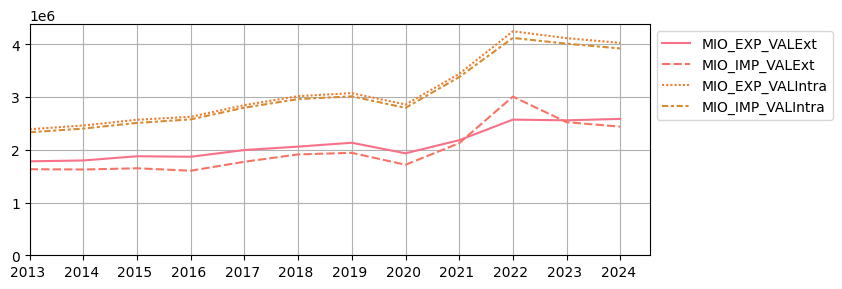

In [173]:
#dicho lo atenrior hacemos la diferenciacion.
cuadro_final1.diff().corr()
cuadro_totales=pd.concat([cuadro1_2.T,cuadro2_2.T])
grafico_lineas(cuadro_totales.T,escala=1000000,tamaño=(8,3))


C:\Users\nevaz\AppData\Local\Temp\ipykernel_11128\1928684117.py:23: UserWarning: The palette list has more values (28) than needed (9), which may not be intended.
  sns.lineplot(x,palette=sns.color_palette("husl", 28))


None

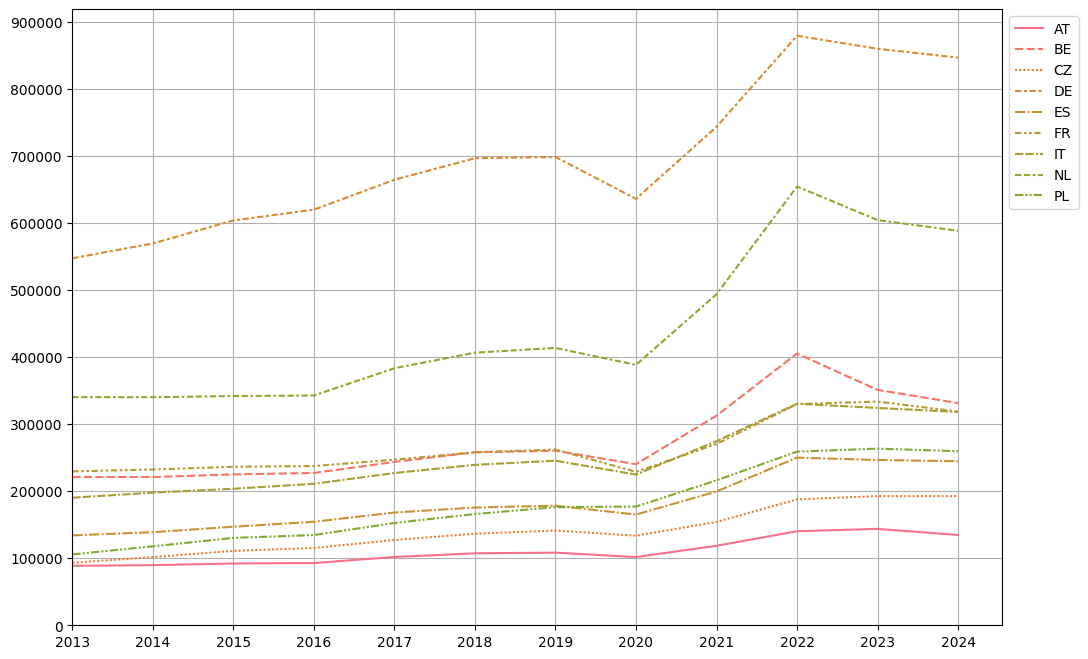

In [174]:
display(paises_mayores_grafico(cuadrosintra["cuadroMIO_EXP_VAL"],2020,90000))

<Axes: >

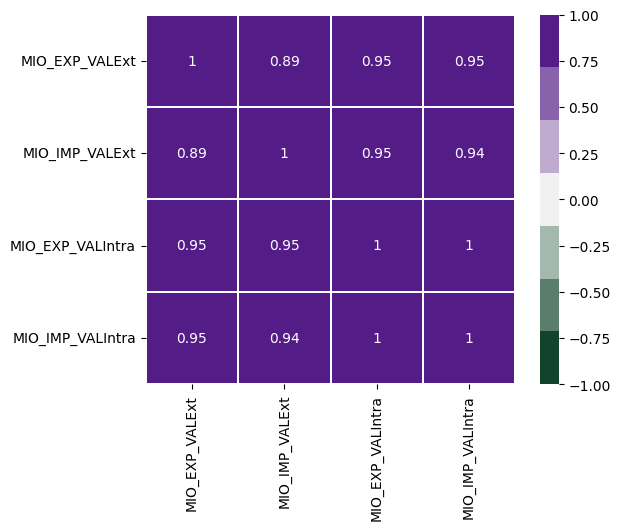

In [175]:
# ahora creamos el cuadro con las correlaciones
sns.heatmap(cuadro_final1.diff().corr(),
            vmin=-1,
            vmax=1,
            cmap=sns.diverging_palette(145, 280, s=85, l=25, n=7),
            square=True,
            linewidths=.1,
            annot=True)

# Conclusiones
Vistos los gráficos arriba realizados se pueden extraer algunas conclusiones sobre los datos relativos a las importaciones/exportaciones tanto dentro como fuera de la UE.
1º La evolucion del comercio:

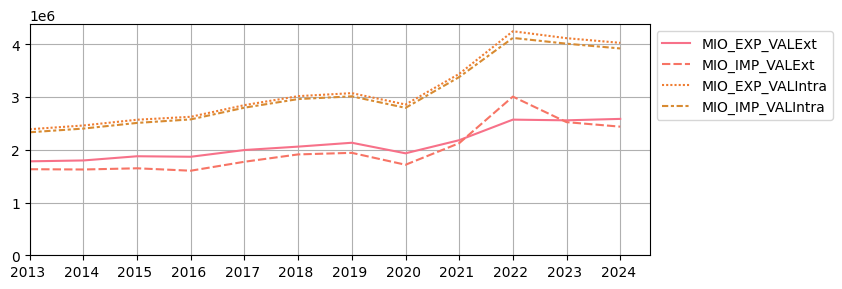



Esto nos revela que estas importaciones provenientes de fuera de la UE, se están aprovechando de los momentos de mayor demanda de los consumidores y empresas de la unión. 
En relación con la epidemia de covid esta se dió entre los años 2020 y 2022, iniciandose en los primeros meses del 2020 y adecabando alrededor de finales del 22. 

Desde el año 2021 las importaciones desde el exterior crecen con fuerza ello ocasiona que sobrepasen a las exportaciones y se mantengan asi hasta el fin de la epidemia del covid, año 2022 cuando vuelven a bajar a niveles mas habituales y por debajo de las exportaciones. En cuanto a las exportaciones fuera de la UE durante la pandemia siguieron aumentando ligeramente para rapidamente extancarse hasta el dia de hoy. En este sentido podemos concluir que la pandemio ha ocasionado un aumento exponencial de las necesidades importadores de la UE. En cuando a las fluctuaciones ocasionales provocadas por la interrupción del canal de suez y el inicio del covid estas no parecen que hubieran tenido un impacto fuera del momento puntual.

Desde el fin del covid las exportaciones europeas a terceros paises se han mantenido en los mismos valores, totalmente estancadas.

Vamos a ver las correlaciones entre las variables:
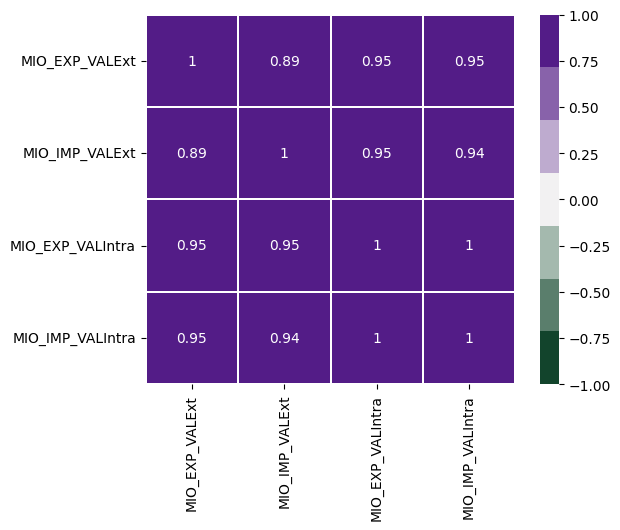

Todas las variables estan fuertemente interrelacionadas de forma que cuando se produce un aumento de las importaciones dentro de la UE tambien se produce un aumento de las importaciones de fuera de la UE. 



